In [16]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.sparse.linalg as ll
import pandas as pd
import scipy.io
from scipy.stats import multivariate_normal as mvn
from kmeans import kmeans
from sklearn.metrics import confusion_matrix

# 3. Implementing EM for MNIST dataset 

In [3]:
data = scipy.io.loadmat('data/data.mat')['data']
label = scipy.io.loadmat('data/label.mat')['trueLabel']

data = np.array(data).T # each row is a data point 
label = np.array(label)

In [98]:
mu_original = np.mean(data, axis = 0, keepdims = True)
ndata = data - mu_original # shape = (784,1990)

m, n = ndata.shape
C = np.matmul(ndata.T, ndata)/m

# pca the data
d = 4  # reduced dimension
V,Gamma,_ = np.linalg.svd(C)
V = V[:, :d]
Gamma = np.diag(Gamma[:d])

# project the data to the top 2 principal directions
# y = label
pdata = np.dot(ndata,V)

In [100]:
np.shape(pdata)

(1990, 4)

In [37]:
# ISyE 6740 Module 7 Demo Code 
K = 2

# random seed
seed = 5

# initialize prior
np.random.seed(seed)
pi = np.random.random(K)
pi = pi/np.sum(pi)

# initial mean and covariance
# np.random.seed(seed)
mu = np.random.randn(K,d)
mu_old = mu.copy()

sigma = []
for ii in range(K):
    # to ensure the covariance psd
    seed = 1 if ii == 0 else 4
    np.random.seed(seed)
    dummy = np.random.randn(d, d)
    sigma.append(dummy@dummy.T + np.eye(d))
    
# initialize the posterior
tau = np.full((m, K), fill_value=0.)

# # parameter for countour plot
# xrange = np.arange(-5, -5, 0.1)
# yrange = np.arange(-5, -5, 0.1)

# ####
maxIter= 100
tol = 1e-3

# plt.ion()
log_likelihood = []    
for ii in range(100):

    # E-step    
    for kk in range(K):
        sigma_det = np.linalg.det(sigma[kk])
        # print(sigma_det)
        tau[:, kk] = pi[kk] * mvn.pdf(pdata, mu[kk], sigma[kk])
        # print(tau[:,kk])
    # normalize tau
    sum_tau = np.sum(tau, axis=1)
    sum_tau.shape = (m,1)    
    tau = np.divide(tau, np.tile(sum_tau, (1, K)))
     
    log_likelihood.append(np.sum(np.log(sum_tau)))
    # M-step
    for kk in range(K):
        # update prior
        pi[kk] = np.sum(tau[:, kk])/m
        
        # update component mean
        mu[kk] = pdata.T @ tau[:,kk] / np.sum(tau[:,kk], axis = 0)
        
        # update cov matrix
        dummy = pdata - np.tile(mu[kk], (m,1)) # X-mu
        sigma[kk] = dummy.T @ np.diag(tau[:,kk]) @ dummy / np.sum(tau[:,kk], axis = 0)
        
    # print('-----iteration---',ii)  
    # tau_color = np.hstack((tau,np.ones((m,1))))  
    # plt.scatter(pdata[:,0], pdata[:,1], c= tau_color)
    # plt.axis('scaled')
    # plt.draw()
    # plt.pause(0.1)
    if np.linalg.norm(mu-mu_old) < tol:
        print('training coverged')
        break
    mu_old = mu.copy()
    if ii==99:
        print('max iteration reached')
        break

training coverged


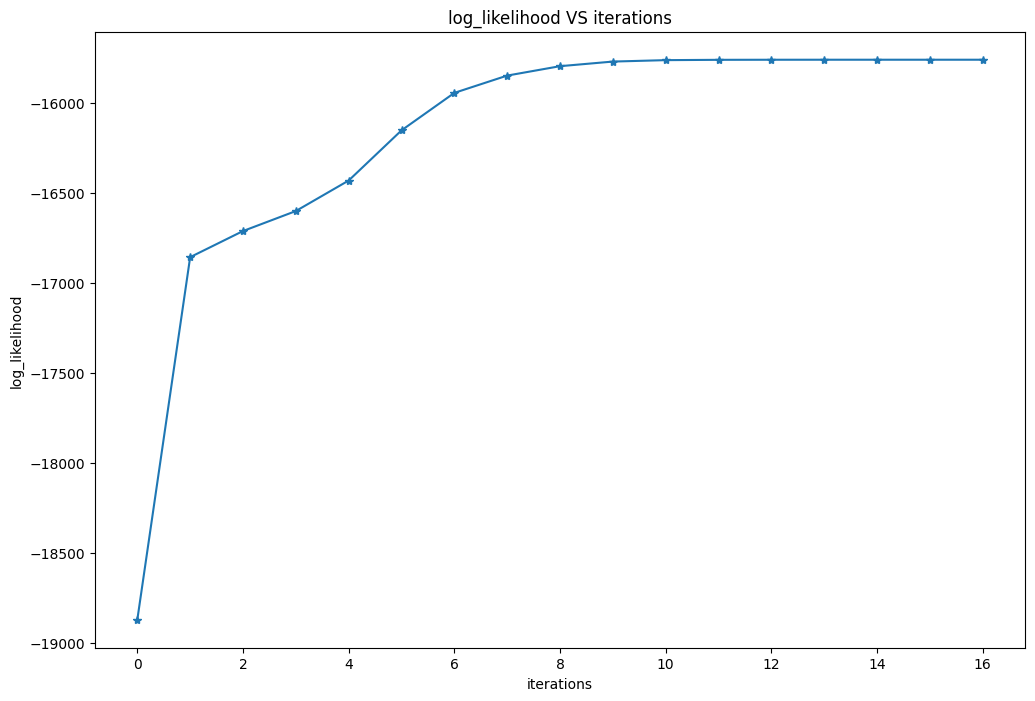

In [38]:
plt.figure(figsize = (12,8))
plt.plot(log_likelihood,'-*')
plt.title('log_likelihood VS iterations')
plt.ylabel('log_likelihood')
plt.xlabel('iterations')

plt.show()

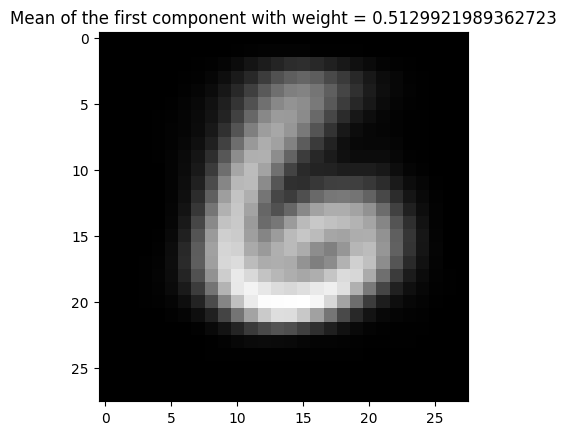

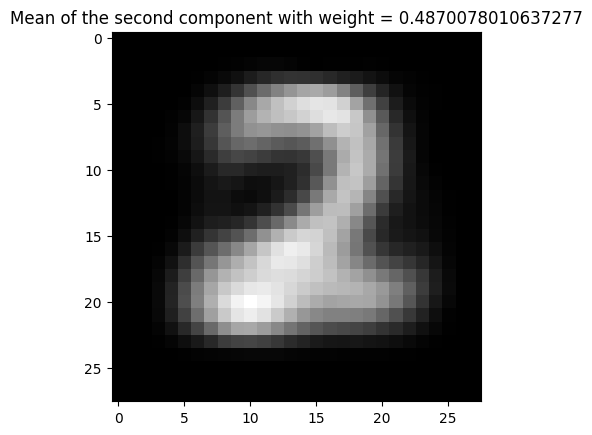

In [97]:
first_mean = (V @ mu[0] + mu_original).reshape((28,28)).T
plt.imshow(first_mean, cmap = 'gray')
plt.title('Mean of the first component with weight = ' + str(pi[0]))

plt.show()

second_mean = (V @ mu[1] + mu_original).reshape((28,28)).T
plt.imshow(second_mean, cmap = 'gray')
plt.title('Mean of the second component with weight = ' + str(pi[1]))

plt.show()



C:\Users\Patrick Gardocki\AppData\Local\Temp\ipykernel_23104\487128021.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet')


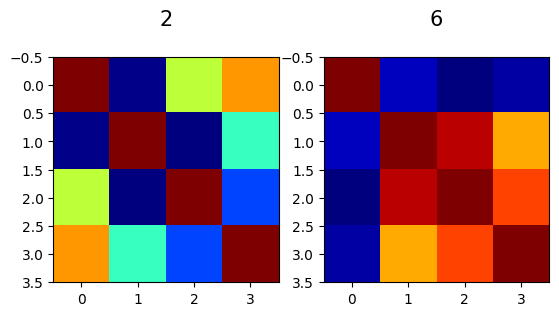

In [96]:
from matplotlib import pyplot as plt
from matplotlib import cm as cm
fig, (ax1, ax2) = plt.subplots(1, 2)

cmap = cm.get_cmap('jet')
V1 = V @ sigma[0]
V2 = V @ sigma[1]
df0 = pd.DataFrame(V1)
df1 = pd.DataFrame(V2)


cax1 = ax1.imshow(df0.corr(), interpolation="nearest", cmap=cmap)
#ax1.grid(True)
ax1.set_title('2\n',fontsize=15)


cax2 = ax2.imshow(df1.corr(), interpolation="nearest", cmap=cmap)
#ax1.grid(True)
ax2.set_title('6\n',fontsize=15)

plt.show()


In [40]:
print(tau[:,0])
label_em = np.argmax(tau,axis = 1)
label_em[label_em == 1] = 2
label_em[label_em == 0] = 6
print('Mis-classification rate for digit' + str('2') + 'is')

label_kmeans, _ = kmeans(pdata,2)
label_kmeans[label_kmeans == 0] = 2
label_kmeans[label_kmeans == 1] = 6

print(confusion_matrix(label[0], label_kmeans))
print(confusion_matrix(label[0], label_em))

label2 = np.where(label == 2, label, 0)
label6 = np.where(label == 6, label, 0)
print(np.sum(label2 == label_em)) # 
print(np.sum(label == 2))


[3.05911305e-02 5.60941340e-05 6.67157602e-02 ... 9.19873197e-01
 9.99999979e-01 9.99999988e-01]
Mis-classification rate for digit2is
(1990,) (1990,) (1990,)
[[ 63 969]
 [882  76]]
[[965  67]
 [  9 949]]
965
1032


In [47]:
confusion_matrix(label[0], label_kmeans)[:,:]

array([[ 63, 969],
       [882,  76]], dtype=int64)